In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

fs = 128

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 32),
    'gamma': (32, 60),
}

data_root = f'{EEG_FOLDER}/EEG_Data'
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']


In [3]:
def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels

    # Filter the data, high pass .5 Hz, low pass 62 Hz.
    lo, hi = .5, 62
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i, c in enumerate(labels)})

    # Z-transform each column
    # dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat


In [4]:
def create_data_set(trials):
    dfs = []
    for trial in trials:
        trial_data = get_trial_data(trial).iloc[:30 * 60 * fs]
        trial_data['ts_sample'] = trial_data.index
        trial_data['trial'] = trial
        trial_data['subject'] = trial // 7
        trial_data['label'] = trial_data.index // (10 * 60 * fs)
        dfs.append(trial_data)
    df = pd.concat(dfs, ignore_index=True)
    return df

df_sub0 = create_data_set([3,4,5,6,7])
df_all_subs = create_data_set([3,4,5,6,7, 10,11,12,13,14, 17,18,19,20,21, 24,25,26,27,28, 31,32,33,34])

In [38]:
len(df_sub0)/128*.8

7200.0

In [5]:
def signal_std_in_window(df, window, columns=None):
    columns = columns or channels
    grouped_df = df.groupby(df.index // window)
    features_df = grouped_df[columns].rolling(window).var().dropna()
    features_df['label'] = grouped_df['label'].rolling(window).max().dropna()
    features_df = features_df.reset_index(drop=True)
    return features_df

def signal_std_by_bands_in_window(df, window):
    trials = df['trial'].unique()
    dfs = []
    for trial in trials:
        trial_df = df[df['trial'] == trial]
        featured_df = pd.DataFrame()
        for ch in channels:
            for band_name, (f_low, f_high) in bands.items():
                featured_df[f'{ch}_{band_name}'] = bp_filter(trial_df[ch], f_low, f_high, fs=fs)
        featured_df['trial'] = trial
        featured_df['label'] = trial_df['label'].values
        dfs.append(featured_df)

    df_std_bands = pd.concat(dfs)
    df_std_bands = df_std_bands.reset_index(drop=True)
    columns = [f'{ch}_{band}' for ch in channels for band in bands.keys()]
    features_df = signal_std_in_window(df_std_bands, window, columns=columns)
    return features_df


# AutoGluon Models

In [15]:
def automl(df):
    # Load your dataframe
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    predictor = TabularPredictor(label='label').fit(train_df)

    # Make predictions on new data
    predictions = predictor.predict(test_df.drop(columns=['label']))
    leaderboard = predictor.leaderboard()

    # Print the leaderboard
    return leaderboard

df = df_all_subs
create_featured_dataset = signal_std_by_bands_in_window

In [ ]:
features_df = create_featured_dataset(df, fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 5 * fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 10 * fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 15 * fs)
automl(features_df)

In [ ]:
features_df = create_featured_dataset(df, 20 * fs)
automl(features_df)

In [ ]:
sub0_std_signal = {}
all_subs_std_signal = {}
sub0_banded_std_signal = {}
all_subs_banded_std_signal = {}
for i in range(1, 21):
    sub0_std_signal[i] = automl(signal_std_in_window(df_sub0, i * fs))
    sub0_std_signal[i]['window'] = i
    all_subs_std_signal[i] = automl(signal_std_in_window(df_all_subs, i * fs))
    all_subs_std_signal[i]['window'] = i
    sub0_banded_std_signal[i] = automl(signal_std_by_bands_in_window(df_sub0, i * fs))
    sub0_banded_std_signal[i]['window'] = i
    all_subs_banded_std_signal[i] = automl(signal_std_by_bands_in_window(df_all_subs, i * fs))
    all_subs_banded_std_signal[i]['window'] = i

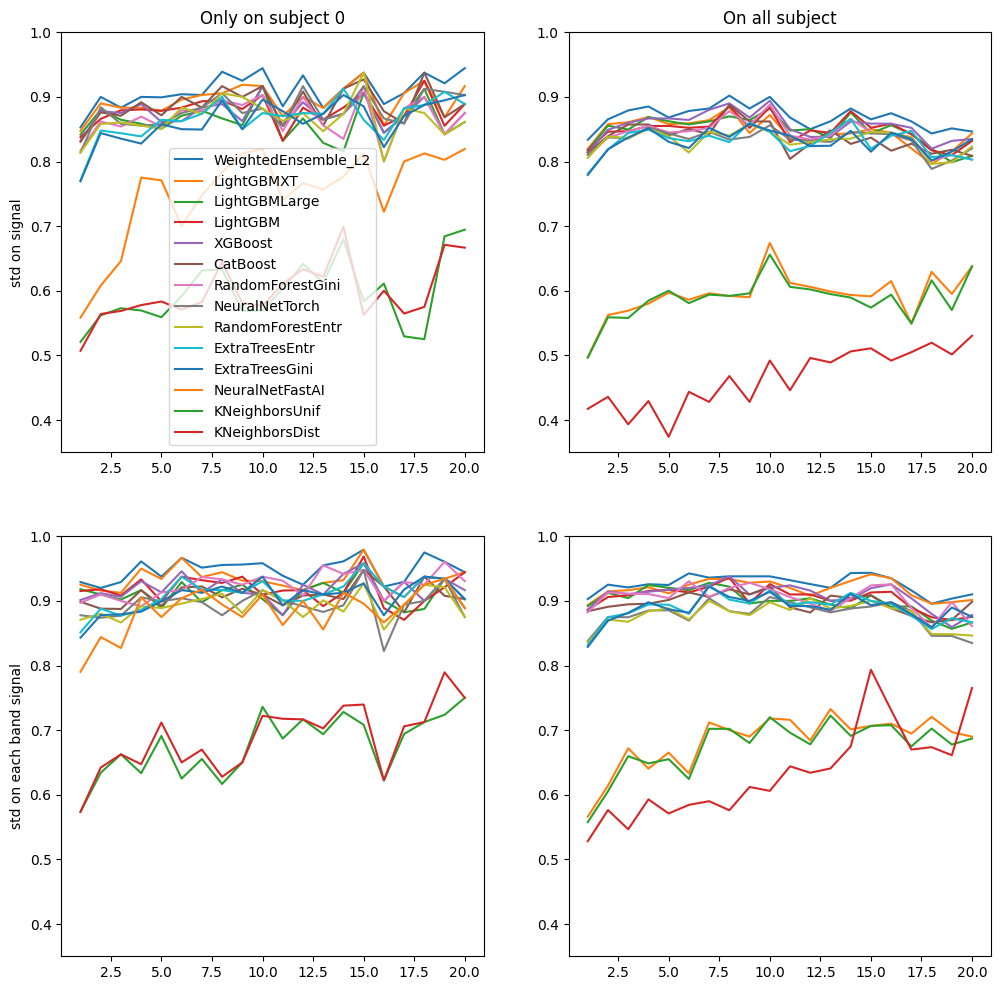

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

results = [sub0_std_signal, all_subs_std_signal, sub0_banded_std_signal, all_subs_banded_std_signal]
for i in range(len(results)):
    ax = axs[i//2][i%2]
    df = pd.concat(list(results[i].values()))
    models = df['model'].unique()
    lines = []
    for model in models:
        x = df.loc[df['model'] == model, 'window']
        y = df.loc[df['model'] == model, 'score_val']
        lines.append(ax.plot(x, y, label=model)[0])
    ax.set_ylim(.35, 1)
    if i == 0:
        ax.legend(handles=lines)
    if i == 0:
        ax.set_ylabel('std on signal')
        ax.set_title('Only on subject 0')
    if i == 1:
        ax.set_title('On all subject')
    if i == 2:
        ax.set_ylabel('std on each band signal')



In [24]:
sub0_std_signal[11]

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,window
0,WeightedEnsemble_L2,0.885496,0.097609,1.319695,0.000000,0.413557,2,True,14,11
1,ExtraTreesGini,0.877863,0.042725,0.442463,0.042725,0.442463,1,True,9,11
2,LightGBMXT,0.870229,0.023056,0.771986,0.023056,0.771986,1,True,4,11
3,ExtraTreesEntr,0.870229,0.045263,0.428846,0.045263,0.428846,1,True,10,11
4,RandomForestEntr,0.862595,0.067652,0.450161,0.067652,0.450161,1,True,7,11
5,CatBoost,0.854962,0.000000,1.676418,0.000000,1.676418,1,True,8,11
6,XGBoost,0.854962,0.002520,1.010250,0.002520,1.010250,1,True,11,11
7,NeuralNetTorch,0.854962,0.010023,3.974878,0.010023,3.974878,1,True,12,11
8,RandomForestGini,0.847328,0.054884,0.463675,0.054884,0.463675,1,True,6,11
9,LightGBMLarge,0.832061,0.000000,3.044844,0.000000,3.044844,1,True,13,11
